In [1]:

import torch

import numpy as np
import open_clip
from open_clip import tokenizer

import random

random.seed(33)

/Users/mrpositron/opt/anaconda3/envs/res/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path2text = './general.txt'

prompts_list = []

with open(path2text, 'r') as f:
    for line in f:
        prompts_list.append(line.strip())


In [3]:
print(prompts_list[:10])

['A futuristic cityscape with flying cars, neon lights, and towering skyscrapers.', 'A mystical forest with a majestic unicorn standing in a clearing, surrounded by glowing flowers.', 'A vibrant underwater world with colorful coral reefs, schools of tropical fish, and a mermaid swimming by.', 'An otherworldly landscape with floating islands, strange rock formations, and a massive portal in the sky.', 'A bustling market in a foreign city, filled with exotic spices, fruits, and handcrafted goods.', 'A dramatic space battle between a fleet of starships and a massive alien mothership, with laser beams and explosions lighting up the scene.', 'A serene mountain landscape with a tranquil lake, towering pine trees, and a small cabin nestled in the woods.', 'A romantic scene with a couple dancing in a moonlit garden, surrounded by blooming flowers and twinkling stars.', 'A post-apocalyptic wasteland with ruins of buildings, abandoned vehicles, and survivors scavenging for resources.', 'A glamor

In [4]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai', )

In [5]:
text_tokens = tokenizer.tokenize(prompts_list)
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()

In [14]:
# comput cosine similarity
cos_sim = np.dot(text_features, text_features.T) / (np.linalg.norm(text_features, axis=1)[:, None] * np.linalg.norm(text_features, axis=1)[None, :])
# delete the diagonal entries from the matrix
for i in range(len(cos_sim)):
    cos_sim[i][i] = 1.0

# find the most similar prompts with thresh and remove them
thresh = 0.8

# shuffle indices
indices = list(range(len(prompts_list)))
random.shuffle(indices)

visited = set()
for i in indices:
    for j in indices:
        if i == j or j < i:
            continue

        if cos_sim[i][j] > thresh:
            visited.add(j)

new_indices = []
for i in indices:
    if i not in visited:
        new_indices.append(i)

new_cos_sim = np.zeros((len(new_indices), len(new_indices)))
new_prompts_list = []
for i in range(len(new_indices)):
    new_prompts_list.append(prompts_list[new_indices[i]])
    for j in range(len(new_indices)):
        new_cos_sim[i][j] = cos_sim[new_indices[i]][new_indices[j]]

print(new_cos_sim.shape)
print(len(new_prompts_list))

(78, 78)
78


In [15]:
# find the closest text prompts using cosine similarity
top_k = 2
closest_ids = new_cos_sim.argsort(axis=1)[:, -top_k:][:, ::-1]

for prompt, closest_id in zip(prompts_list, closest_ids):
    print(prompt)
    for idx in closest_id[1:]: # exclude the first one, which is the prompt itself
        print(new_prompts_list[idx])
    break

A futuristic cityscape with flying cars, neon lights, and towering skyscrapers.
A cozy cabin in the woods scene with a warm fire, hot cocoa, and a group of friends snuggled up with blankets, reading books and telling stories.


In [23]:
from sklearn.cluster import KMeans

k = 15

distance_matrix = new_cos_sim

# k-means clustering
# finds the closest point to the centroid of each cluster
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=33, n_init=100, max_iter=1000)
kmeans.fit(distance_matrix)

centroids = kmeans.cluster_centers_

k_points = []
for i in range(k):
    # find the closest point to the centroid of each cluster
    # that ensures that points will be spread out
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    closest_point = cluster_indices[np.argmin(distance_matrix[cluster_indices][:, cluster_indices].sum(axis=0))]
    k_points.append(closest_point)

print(k_points)

[12, 53, 7, 17, 62, 41, 44, 52, 42, 70, 9, 40, 2, 8, 21]


In [24]:
temp = new_cos_sim[k_points, :][:, k_points]
temp = temp - np.eye(temp.shape[0])

dissimilarity_coef = (temp.sum() // 2) / (temp.shape[0] * (temp.shape[0] - 1) / 2)
print(f"Mean distance, i.e. cosine similarity, is {round(dissimilarity_coef, 4)}")

Mean distance, i.e. cosine similarity, is 0.419


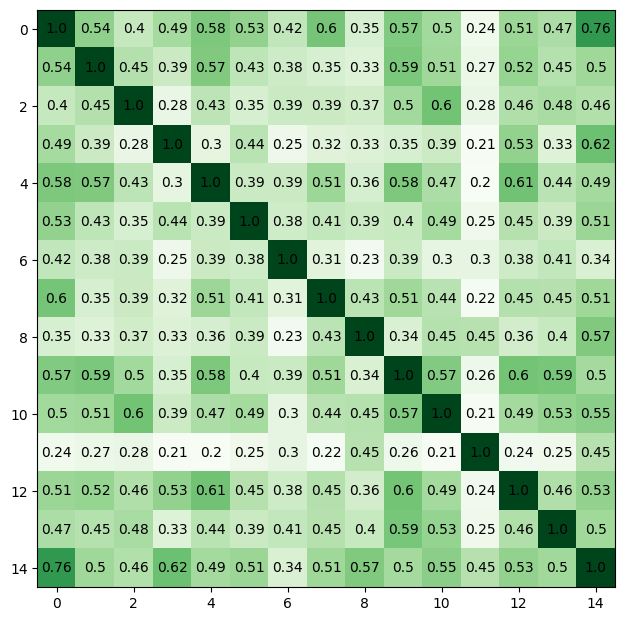

In [25]:
# distance between the most dissimilar prompts
# plot it color coded as a heatmap
import matplotlib.pyplot as plt


scale = 0.5
plt.figure(figsize=(len(k_points) * scale, len(k_points) * scale))
plt.imshow(distance_matrix[k_points, :][:, k_points], cmap='Greens', interpolation='nearest')
# put values in the cells
for i in range(k):
    for j in range(k):
        plt.text(j, i, round(distance_matrix[k_points[i]][k_points[j]], 2), ha='center', va='center', color='black')
plt.show()


In [26]:
# Most dissimilar prompts
for idx in k_points:
    print(new_prompts_list[idx])

An exciting and adrenaline-fueled scene of a hot air balloon race over a vast canyon.
A spooky and eerie abandoned carnival scene with empty rides, broken lights, and a creepy clown lurking in the shadows.
A mystical and spiritual scene of a meditating monk in a temple surrounded by cherry blossoms.
A dreamy and surreal cloudscape scene with fluffy white clouds, a rainbow, and a hot air balloon floating in the distance.
A dynamic and exciting skateboard park with jumps, ramps, and half-pipes, surrounded by the city skyline.
A majestic and awe-inspiring scene of a safari in Africa with elephants, lions, and a beautiful sunset in the background.
A vibrant and colorful scene of a street market in Marrakech, Morocco with spices, textiles, and street performers.
A dramatic mountain climber scene with a group of mountaineers scaling a sheer cliff face, braving wind and cold to reach the summit.
A romantic and picturesque scene of a couple stargazing in a field at night, with shooting stars a

In [27]:
# find the index of the maximum value in the matrix temp
i, j = np.unravel_index(np.argmax(temp), temp.shape)
print(f"Most similar prompts are: \n{new_prompts_list[k_points[i]]} \n{new_prompts_list[k_points[j]]}")


Most similar prompts are: 
An exciting and adrenaline-fueled scene of a hot air balloon race over a vast canyon. 
A romantic and dreamy scene of a couple in a hot air balloon, floating over a picturesque countryside.


In [32]:
[new_prompts_list[i] for i in k_points]

['An exciting and adrenaline-fueled scene of a hot air balloon race over a vast canyon.',
 'A spooky and eerie abandoned carnival scene with empty rides, broken lights, and a creepy clown lurking in the shadows.',
 'A mystical and spiritual scene of a meditating monk in a temple surrounded by cherry blossoms.',
 'A dreamy and surreal cloudscape scene with fluffy white clouds, a rainbow, and a hot air balloon floating in the distance.',
 'A dynamic and exciting skateboard park with jumps, ramps, and half-pipes, surrounded by the city skyline.',
 'A majestic and awe-inspiring scene of a safari in Africa with elephants, lions, and a beautiful sunset in the background.',
 'A vibrant and colorful scene of a street market in Marrakech, Morocco with spices, textiles, and street performers.',
 'A dramatic mountain climber scene with a group of mountaineers scaling a sheer cliff face, braving wind and cold to reach the summit.',
 'A romantic and picturesque scene of a couple stargazing in a fie

In [35]:
# save the prompts
with open('./filtered_prompts.txt', 'w') as f:
    for i in k_points:
        f.write(new_prompts_list[i])
        if i != k_points[-1]:
            f.write('\n')